In [1]:
import random
import os
import json
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.optim import AdamW
import torchmetrics
from transformers import RobertaTokenizerFast, AutoModel
from transformers import get_scheduler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from tqdm.auto import tqdm

random.seed(42)
reshuffle_docs = False

percent_to_test = .1
percent_to_dev = .2
percent_to_train =  1 - percent_to_dev - percent_to_test

batch_size = 10 # documents
learning_rate = 2e-4
n_epochs = 10

type = 'Quantity'

model_name = 'allenai/biomed_roberta_base'

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

data_size_reduce = 1 # multiplier for making small datasets

In [2]:
class OurBERTModel(nn.Module):
    def __init__(self):
        super(OurBERTModel, self).__init__()
        self.mod = AutoModel.from_pretrained(model_name)
        self.drop = nn.Dropout(self.mod.config.hidden_dropout_prob)
        self.classifier = nn.Linear(self.mod.config.hidden_size, 2)

    def forward(self, text, att_mask):
        b, num_tokens = text.shape
        token_type = torch.zeros((b, num_tokens), dtype=torch.long).to(device)
        outputs = self.mod(text, attention_mask=att_mask, token_type_ids=token_type)
        return self.classifier(self.drop(outputs['last_hidden_state']))

model = OurBERTModel()

print(sum(p.numel() for p in model.parameters()),"parameters!")
model = model.to(device)
print("Detected", torch.cuda.device_count(), "GPUs!")

Some weights of the model checkpoint at allenai/biomed_roberta_base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


124647170 parameters!
Detected 1 GPUs!


In [3]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=learning_rate)
f1_f = torchmetrics.F1Score(mdmc_average='samplewise')
acc_f = torchmetrics.Accuracy(mdmc_average='samplewise')

In [4]:
currentdir = os.getcwd() # ~/MeasEval/baselines

combopath_txt = os.path.join(currentdir, "../data/raw/combo/text/")
combopath_annot = os.path.join(currentdir, "../data/raw/combo/tsv/")

interimpath = os.path.join(currentdir, "../data/interim/")



if reshuffle_docs == True:
    docIds = []
    combo_txt = {}
    for fn in os.listdir(combopath_txt):
        docIds.append(fn[:-4])
        path = combopath_txt+fn
        with open(path) as textfile:
                text = textfile.read()
                #[:-4] strips off the .txt to get the id
                combo_txt[fn[:-4]] = text

    combo_annot = pd.DataFrame()
    for fn in os.listdir(combopath_annot):
        path = combopath_annot+fn
        file = pd.read_csv(path,delimiter='\t',encoding='utf-8')
        combo_annot = pd.concat([combo_annot, file],ignore_index=True)

    random.shuffle(docIds)

    n_doc = len(docIds)
    split_train = int(np.round(n_doc * percent_to_train))
    split_dev = split_train + int(np.round(n_doc * percent_to_dev))

    docs_train = docIds[:split_train]
    docs_dev = docIds[split_train:split_dev]
    docs_test = docIds[split_dev:]

    train_annot = combo_annot.loc[combo_annot['docId'].isin(docs_train)]
    dev_annot = combo_annot.loc[combo_annot['docId'].isin(docs_dev)]
    test_annot = combo_annot.loc[combo_annot['docId'].isin(docs_test)]

    # save data
    train_annot.to_csv(interimpath+'train_annot.csv')
    dev_annot.to_csv(interimpath+'dev_annot.csv')
    test_annot.to_csv(interimpath+'test_annot.csv')

    train_txt = {d: combo_txt[d] for d in docs_train}
    dev_txt = {d: combo_txt[d] for d in docs_dev}
    test_txt = {d: combo_txt[d] for d in docs_test}
    
    with open(interimpath+'train_txt.json','w') as f:
        json.dump(train_txt, f)
    with open(interimpath+'dev_txt.json','w') as f:
        json.dump(dev_txt, f)
    with open(interimpath+'test_txt.json','w') as f:
        json.dump(test_txt, f)

else:
    train_annot = pd.read_csv(interimpath+'train_annot.csv')
    dev_annot = pd.read_csv(interimpath+'dev_annot.csv')
    test_annot = pd.read_csv(interimpath+'test_annot.csv')

    with open(interimpath+'train_txt.json','r') as f:
        train_txt = json.load(f)
    with open(interimpath+'dev_txt.json','r') as f:
        dev_txt = json.load(f)
    with open(interimpath+'test_txt.json','r') as f:
        test_txt = json.load(f)

train_docIds = list(set(train_annot['docId']))
dev_docIds = list(set(dev_annot['docId']))
test_docIds = list(set(test_annot['docId']))

In [5]:
########## Tokenizer ###########

tokenizer = RobertaTokenizerFast.from_pretrained(model_name)



In [6]:
def tokenize_and_align_labels(docs_or_sents, txt, annotation, type=type, tokenizer=tokenizer):
    
    toks_with_labels = []

    for doc in docs_or_sents:
        # print(doc)

        encoded_txt = tokenizer(txt[doc], padding='max_length', max_length=512, truncation=True)
        # print(encoded_txt)

        encoded_tokens = encoded_txt['input_ids']
        # print(encoded_tokens)

        doc_annot = annotation.loc[annotation['docId'] == doc]
        # print(doc_annot)

        annot_spans = np.array(doc_annot[['startOffset','endOffset']])
        # print(f'annot_spans={annot_spans}')

        label_ids = np.full(len(encoded_tokens),0)
        special_ids = tokenizer.all_special_ids
        # print(label_ids.shape)

        for token_idx, token in enumerate(encoded_tokens):
            # decoded_token = tokenizer.decode(token)
            # print(f"token index: {token_idx}")
            # print(f"decoded token: {decoded_token}")

            if token in special_ids:
                label_ids[token_idx] = 0
                # print('special token')

            else:
                token_start_char = encoded_txt.token_to_chars(token_idx).start
                token_end_char = encoded_txt.token_to_chars(token_idx).end
                # print(f"token span: {[token_start_char,token_end_char]}")
                for start, end in annot_spans:
                    if start <= token_start_char <= end:
                        label_ids[token_idx] = 1
                        # print(f'{type} entity found spanning {[start,end]}')
                        break
                    else:
                        label_ids[token_idx] = 0
                        # print("no entity found")
        
        encoded_txt['doc_or_sent_id'] = doc
        encoded_txt['labels'] = list(label_ids)
        toks_with_labels.append(encoded_txt)
    # return toks_with_labels
    return pd.DataFrame.from_dict(toks_with_labels)

In [7]:
################# TOKENIZE #################
train_docIds = random.sample(train_docIds, int(len(train_docIds)*data_size_reduce))

quant_train_dataset = tokenize_and_align_labels(
    docs_or_sents=train_docIds,
    txt=train_txt,
    annotation=train_annot,
    type=type,
    tokenizer=tokenizer)
num_train_docs = quant_train_dataset.shape[0]

dev_docIds = random.sample(dev_docIds, int(len(dev_docIds)*data_size_reduce))

quant_dev_dataset = tokenize_and_align_labels(
    docs_or_sents=dev_docIds,
    txt=dev_txt,
    annotation=dev_annot,
    type=type,
    tokenizer=tokenizer)
num_dev_docs = quant_dev_dataset.shape[0]

test_docIds = test_docIds

quant_test_dataset = tokenize_and_align_labels(
    docs_or_sents=test_docIds,
    txt=test_txt,
    annotation=test_annot,
    type=type,
    tokenizer=tokenizer)
num_test_docs = quant_test_dataset.shape[0]


In [8]:
quant_train_dataset.head()

,attention_mask,doc_or_sent_id,input_ids,labels
0,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",S2213158213000582-766,"[0, 37257, 12, 13839, 20070, 13, 727, 43601, 1...","[0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, ..."
1,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",S2211124712002884-682,"[0, 1640, 347, 43, 6007, 2301, 545, 8, 601, 6,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",S037842901300244X-1801,"[0, 28084, 7, 5, 9186, 7511, 9, 5, 36679, 9209...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",S0012821X12004384-1232,"[0, 1620, 820, 73, 698, 102, 12, 306, 16, 11, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, ..."
4,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",S0301010413004096-767,"[0, 15102, 19416, 763, 58, 2673, 15, 5, 255, 3...","[0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [9]:
def batchify(tokenized_dataset, batch_size):
    num_examples = int(tokenized_dataset.shape[0] / batch_size)
    batch_sizes = [batch_size for x in range(num_examples)]
    last_batch_size = tokenized_dataset.shape[0] % batch_size
    if last_batch_size:
        batch_sizes.append(last_batch_size)
    # print(batch_sizes)

    batched_dataset = []

    for idx, size in enumerate(batch_sizes):
        start = sum(batch_sizes[:idx])
        end = sum(batch_sizes[:idx]) + size - 1
        # print(start,end,idx)
        input_ids = torch.LongTensor(tokenized_dataset['input_ids'].loc[start:end].tolist()).to(device)
        attention_mask = torch.LongTensor(tokenized_dataset['attention_mask'].loc[start:end].tolist()).to(device)
        labels = torch.LongTensor(tokenized_dataset['labels'].loc[start:end].tolist()).to(device)
        # print(labels.shape)
        doc_or_sent_id = list(tokenized_dataset['doc_or_sent_id'].loc[start:end])
        
        batch = {
            'input_ids':input_ids,
            'labels':labels,
            'attention_mask':attention_mask,
            'doc_or_sent_id':doc_or_sent_id

        }
        
        batched_dataset.append(batch)

    return batched_dataset



In [10]:
################# batchify ####################
batched_quant_train_ds = batchify(quant_train_dataset, batch_size=batch_size)
batched_quant_dev_ds = batchify(quant_dev_dataset, batch_size=batch_size)
batched_quant_test_ds = batchify(quant_test_dataset, batch_size=batch_size)


In [11]:
batched_quant_train_ds[0]

{'input_ids': tensor([[    0, 37257,    12,  ...,     1,     1,     1],
         [    0,  1640,   347,  ...,     1,     1,     1],
         [    0, 28084,     7,  ...,     1,     1,     1],
         ...,
         [    0,   133,  4049,  ...,     1,     1,     1],
         [    0,  2522,  1421,  ...,     1,     1,     1],
         [    0, 44189,  3868,  ...,     1,     1,     1]], device='cuda:0'),
 'labels': tensor([[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]], device='cuda:0'),
 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]], device='cuda:0'),
 'doc_or_sent_id': ['S2213158213000582-766',
  'S2211124712002884-682',
  'S0378429013

In [12]:
logger = {
    'train_batches':[],
    'train_losses':[],
    'eval_batches':[],
    'eval_losses':[],
}

num_epochs = n_epochs
num_training_steps = num_epochs * len(batched_quant_train_ds)
lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

def train_batch(ds=batched_quant_train_ds):

    model.train()
    for idx, batch in enumerate(ds):
        logger['train_batches'].append(idx+1)
        
        labels = batch['labels']
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        
        output = model(input_ids, attention_mask)
        logits = output.permute(0,2,1)
        
        loss = criterion(logits, labels)
        logger['train_losses'].append(loss.item())

        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()

        predictions = torch.argmax(logits, dim=1)
        last = attention_mask[0].sum()
        y_pred = []
        y_true = []
        for i in range(predictions.shape[0]):
            last_tok = attention_mask[i].sum()-1
            y_pred.append(predictions[i][:last_tok].cpu().numpy())
            y_true.append(labels[i][:last_tok].cpu().numpy())

        y_true = np.concatenate(y_true).ravel()
        y_pred = np.concatenate(y_pred).ravel()

        progress_bar.update(1)
            
    return


def eval_batch(ds=batched_quant_dev_ds):
    model.eval()
    with torch.no_grad():
        for idx, batch in enumerate(ds):
            logger['eval_batches'].append(idx+1)

            labels = batch['labels']
            input_ids = batch['input_ids']
            attention_mask = batch['attention_mask']

            output = model(input_ids, attention_mask)
            logits = output.permute(0,2,1)
            
            loss = criterion(logits, labels)
            logger['eval_losses'].append(loss.item())
            
            predictions = torch.argmax(logits, dim=1)
            y_pred = []
            y_true = []
            for i in range(predictions.shape[0]):
                last_tok = attention_mask[i].sum()-1
                y_pred.append(predictions[i][:last_tok].cpu().numpy())
                y_true.append(labels[i][:last_tok].cpu().numpy())

            y_true = np.concatenate(y_true).ravel()
            y_pred = np.concatenate(y_pred).ravel()

    return y_true, y_pred


In [13]:
progress_bar = tqdm(range(num_training_steps))


for epoch in range(num_epochs):
    
    print(f"\n============ Begin Epoch {epoch+1} ============")

    train_batch(batched_quant_train_ds)
    
    y_true_train, y_pred_train = eval_batch(batched_quant_train_ds)
    print('Training Set Classification Report:')
    train_report = classification_report(y_true_train, y_pred_train,
                    target_names=[str('Not '+type),type],output_dict=True, zero_division=0)
    print(train_report[type])

    y_true_dev, y_pred_dev = eval_batch(batched_quant_dev_ds)
    print('\nDev Set Classification Report:')
    dev_report = classification_report(y_true_dev, y_pred_dev,
                    target_names=[str('Not '+type),type],output_dict=True, zero_division=0)
    print(dev_report[type])


  0%|          | 0/300 [00:00<?, ?it/s]


============ Begin Epoch 1 ============
Training Set Classification Report:
{'precision': 0.8004291845493562, 'recall': 0.758130081300813, 'f1-score': 0.778705636743215, 'support': 492}

Dev Set Classification Report:
{'precision': 0.8811881188118812, 'recall': 0.7007874015748031, 'f1-score': 0.7807017543859649, 'support': 254}

============ Begin Epoch 2 ============
Training Set Classification Report:
{'precision': 0.8407766990291262, 'recall': 0.8800813008130082, 'f1-score': 0.8599801390268123, 'support': 492}

Dev Set Classification Report:
{'precision': 0.8959276018099548, 'recall': 0.7795275590551181, 'f1-score': 0.8336842105263158, 'support': 254}

============ Begin Epoch 3 ============
Training Set Classification Report:
{'precision': 0.887189292543021, 'recall': 0.943089430894309, 'f1-score': 0.9142857142857144, 'support': 492}

Dev Set Classification Report:
{'precision': 0.9162790697674419, 'recall': 0.7755905511811023, 'f1-score': 0.8400852878464818, 'support': 254}

====

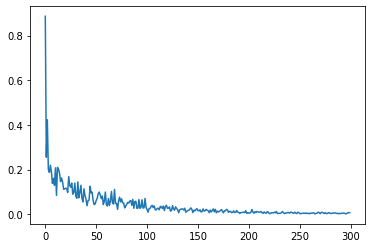

In [14]:
########################## training loss plot #######################

import matplotlib.pyplot as plt
y = np.array(logger['train_losses'])
x = np.array(range(len(logger['train_batches'])))
plt.plot(x,y)
plt.show()

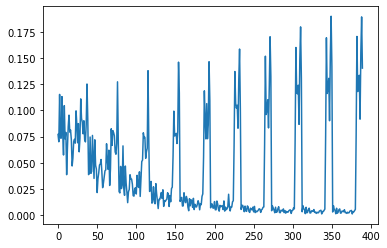

In [15]:
########################## eval loss plot #######################

import matplotlib.pyplot as plt
x = np.array(range(len(logger['eval_batches'])))
y = np.array(logger['eval_losses'])
plt.plot(x,y)
plt.show()

In [ ]:
###################### single batch training debugging ######################
# batch = batched_quant_train_ds[0]

# model.train()

# labels = batch['labels']
# # print(labels)
# input_ids = batch['input_ids']
# # print(input_ids)
# attention_mask = batch['attention_mask']
# # print(attention_mask)

# outputs = model(input_ids, attention_mask)
# logits = outputs

# train_loss = criterion(logits.permute(0,2,1), labels)

# train_loss.backward()
# optimizer.step()
# lr_scheduler.step()
# optimizer.zero_grad()

In [ ]:
###################### single batch prediction debugging ######################

# batch = batched_quant_dev_ds[0]

# model.eval()

# with torch.no_grad():
#     labels = batch['labels']
#     input_ids = batch['input_ids']
#     attention_mask = batch['attention_mask']

#     output = model(input_ids, attention_mask)
#     logits = output.permute(0,2,1)

#     loss = criterion(logits, labels)
#     logger['eval_losses'].append(loss.item())

#     predictions = torch.argmax(logits, dim=1)
#     accuracy = acc_f(labels,predictions).item()
#     print(accuracy)
#     f1 = f1_f(labels,predictions).item()
#     print(f1)

#     # labels = labels[0].cpu().numpy()
#     # predictions = predictions[0].cpu().numpy()

#     # confusion_matrix(labels,predictions[0].cpu().numpy())
# print(predictions.shape)
# print(attention_mask.shape)
# print(labels.shape)
# print(torch.sum(attention_mask[0]))
# # np.nonzero(attention_mask[0])[-1].item()
# last = attention_mask[0].sum()
# y_pred = []
# y_true = []
# for i in range(predictions.shape[0]):
#     last_tok = attention_mask[i].sum()-1
#     y_pred.append(predictions[i][:last_tok].cpu().numpy())
#     y_true.append(labels[i][:last_tok].cpu().numpy())

# y_true = np.concatenate(y_true).ravel()
# y_pred = np.concatenate(y_pred).ravel()

# y_true.shape
# y_pred.shape
# classification_report(y_true, y_pred, output_dict=True)['1']

0.810302734375
0.810302734375
